In [1]:
import pandas as pd
from textdistance import hamming
import numpy as np
from ast import literal_eval
import seaborn as sns
from pathlib  import Path
import matplotlib.pyplot as plt
from Bio.Seq import translate
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from Bio.codonalign.codonseq import cal_dn_ds, CodonSeq
from pandarallel import pandarallel
pandarallel.initialize()  # You can turn off progress bar if you like
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

/home/athenes/.pyenv/versions/analysis/lib/python3.10/site-packages/Bio/codonalign/__init__.py:23: BiopythonExperimentalWarning: Bio.codonalign is an experimental module which may undergo significant changes prior to its future official release.
  warnings.warn(


INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
igG_germline = pd.concat([pd.read_csv(f"/home/athenes/Paraplume/data_with_scripts/repertoire_analysis/briney/splits_unique_G/paratope_IgG_unique_germline_{each}.csv.gz", usecols=["model_prediction_heavy","sequence_heavy","sequence_light"]) for each in range(900) if Path(f"/home/athenes/Paraplume/data_with_scripts/repertoire_analysis/briney/splits_unique_G/paratope_IgG_unique_germline_{each}.csv.gz").exists()])
igG_sequence = pd.concat([pd.read_csv(f"/home/athenes/Paraplume/data_with_scripts/repertoire_analysis/briney/splits_unique_G/paratope_IgG_unique_sequence_{each}.csv.gz", usecols=["model_prediction_heavy","sequence_heavy","sequence_light"]) for each in range(900) if Path(f"/home/athenes/Paraplume/data_with_scripts/repertoire_analysis/briney/splits_unique_G/paratope_IgG_unique_sequence_{each}.csv.gz").exists()])

In [3]:
briney = pd.read_table("/home/athenes/Paraplume/data_with_scripts/repertoire_analysis/briney/316188_clonal_groups_with_aa.tsv.gz").dropna()
igG=briney.query("isotype.str.startswith('IgG')")

In [4]:
prediction_map = igG_sequence.set_index('sequence_heavy')['model_prediction_heavy'].to_dict()
igG['model_prediction_heavy_sequence'] = igG['sequence_aa'].map(prediction_map)
prediction_map = igG_germline.set_index('sequence_heavy')['model_prediction_heavy'].to_dict()
igG['model_prediction_heavy_germline'] = igG['germline_aa'].map(prediction_map)

/tmp/ipykernel_2366694/2838842722.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  igG['model_prediction_heavy_sequence'] = igG['sequence_aa'].map(prediction_map)
/tmp/ipykernel_2366694/2838842722.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  igG['model_prediction_heavy_germline'] = igG['germline_aa'].map(prediction_map)


In [5]:
import json
def process_df(df):
    df["paratope_heavy_sequence"]=df["model_prediction_heavy_sequence"].parallel_apply(json.loads)
    df["paratope_size_sequence"]=df["paratope_heavy_sequence"].parallel_apply(np.sum)
    df["normalized_paratope_size_sequence"]=df["paratope_size_sequence"]/df["sequence_aa"].str.len()

    df["paratope_heavy_germline"]=df["model_prediction_heavy_germline"].parallel_apply(json.loads)
    df["paratope_size_germline"]=df["paratope_heavy_germline"].parallel_apply(np.sum)
    df["normalized_paratope_size_germline"]=df["paratope_size_germline"]/df["germline_aa"].str.len()

    df["mutation_count"]=df[["sequence_aa", "germline_aa"]].parallel_apply(
            lambda x: hamming(*x),
            axis=1,
        )
    return df

In [6]:
ig_filtered = process_df(igG.dropna())
ig_filtered["delta_paratope_size"]=ig_filtered["paratope_size_sequence"]-ig_filtered["paratope_size_germline"]

/tmp/ipykernel_2366694/3502409425.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["paratope_heavy_sequence"]=df["model_prediction_heavy_sequence"].parallel_apply(json.loads)
/tmp/ipykernel_2366694/3502409425.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["paratope_size_sequence"]=df["paratope_heavy_sequence"].parallel_apply(np.sum)
/tmp/ipykernel_2366694/3502409425.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [7]:
print(len(ig_filtered))

3506538


In [8]:
plt.rcParams.update({
    "axes.labelsize": 30,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "legend.fontsize": 20,
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
})

# density map

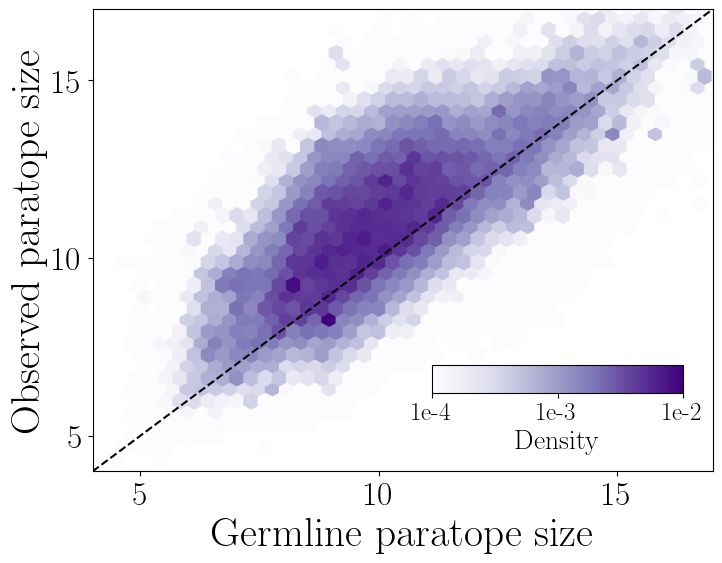

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np

# Extract data
x = ig_filtered["paratope_size_germline"].values
y = ig_filtered["paratope_size_sequence"].values

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
hb = ax.hexbin(
    x, y,
    gridsize=60,
    cmap="Purples",
    mincnt=10
)
counts = hb.get_array()
n_total = len(x)

density = counts / n_total

# Normalize and apply density
norm = LogNorm(vmin=1e-4, vmax=1e-2)
hb.set_array(density)
hb.set_norm(norm)

# Plot reference line
x_range = np.linspace(4, 17, 400)
ax.plot(x_range, x_range, color="black", linestyle="--", label=r"$y=x$")

# Axis settings
ticks = [5, 10, 15]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xlabel(r"Germline paratope size")
ax.set_ylabel(r"Observed paratope size")
ax.set_xlim([4, 17])
ax.set_ylim([4, 17])

# Colorbar
sm = ScalarMappable(cmap="Purples", norm=norm)
sm.set_array([])
cax = inset_axes(
    ax,
    width="45%", height="3%",
    loc='lower center',
    bbox_to_anchor=(0.3, 0.17, 0.9, 2),
    bbox_transform=ax.transAxes,
    borderpad=0
)
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label(r"Density", fontsize=20)
cbar.set_ticks([1e-4, 1e-3,1e-2])
cbar.set_ticklabels(["1e-4", "1e-3","1e-2"])
cbar.ax.tick_params(labelsize=18)  # Hides the tick marks
cbar.ax.minorticks_off()
plt.savefig("/home/athenes/Paraplume/data_with_scripts/plots/figure5A.svg")
plt.show()


# stripplot

In [10]:
from scipy.stats import pearsonr
plt.rcParams.update({
    "axes.labelsize": 30,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "legend.fontsize": 20,
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
})
def plot_mut(mutation_count_germlines, paratope_size_germlines, mutation_count_sequences, paratope_size_sequences, save_name=None, right=False, title=""):
    """
    Plots a strip plot with overlayed mean markers showing paratope size distribution for bins of mutation counts of size 2.
    The left side represents 'immunized_germlines' and the right side represents 'immunized_sequences'.

    Parameters:
    - mutation_count_germlines: List or array of mutation counts for germlines.
    - paratope_size_germlines: List or array of corresponding paratope sizes for germlines.
    - mutation_count_sequences: List or array of mutation counts for sequences.
    - paratope_size_sequences: List or array of corresponding paratope sizes for sequences.
    - save_name: (Optional) If provided, saves the plot to the given filename.
    """
    # Create DataFrames for both datasets
    r_value, p_value=pearsonr(paratope_size_sequences,mutation_count_sequences)
    print(r_value)
    print(p_value)
    each_germlines = pd.DataFrame({"Mutation Count": mutation_count_germlines, "Paratope Size": paratope_size_germlines, "Type": r"Inferred germlines"})
    each_sequences = pd.DataFrame({"Mutation Count": mutation_count_sequences, "Paratope Size": paratope_size_sequences, "Type": r"Observed sequences"})

    # Concatenate the data
    each = pd.concat([each_germlines, each_sequences], ignore_index=True)

    # Define bins of size 2
    bins = range(0, int(each["Mutation Count"].max()) + 3, 3)
    bin_labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins) - 1)]
    each["Mutation Bin"] = pd.cut(each["Mutation Count"], bins=bins, labels=bin_labels, right=True)

    # Convert to categorical with a specific order
    each["Mutation Bin"] = pd.Categorical(each["Mutation Bin"], categories=bin_labels, ordered=True)

    # Strip plot
    plt.figure(figsize=(8, 6))
    sns.stripplot(x="Mutation Bin", y="Paratope Size", hue="Type", data=each, dodge=True, alpha=0.002, size=1, legend=False, palette={"Inferred germlines": "#1a80bb", "Observed sequences": "#a00000"})
    sns.pointplot(x="Mutation Bin", y="Paratope Size", hue="Type", data=each, dodge=0.4, linestyle="none", errorbar=None, marker="_", markersize=25, markeredgewidth=4, palette={"Inferred germlines": "#1a80bb", "Observed sequences": "#a00000"})
    plt.xlabel(r"Mutation count")
    if right:
        plt.ylabel("")
    else:
        plt.ylabel(r"Paratope size")

    plt.ylim([4, 16])
    ticks = [5, 10, 15]
    plt.yticks(ticks)
    plt.xticks(rotation=45)  # rotate x-tick labels

    legend=plt.legend(
        loc="lower left",
        bbox_to_anchor=(-0.003, -0.0),
        frameon=True,
        borderaxespad=0.1,
        handletextpad=0.2,
        labelspacing=0.1,
    )
    legend.get_frame().set_facecolor("white")       # Set background color
    legend.get_frame().set_alpha(0.8)
    plt.savefig("/home/athenes/Paraplume/data_with_scripts/plots/figure5B.png", bbox_inches="tight", dpi=300)
    plt.show()


0.09268454476207894
0.0


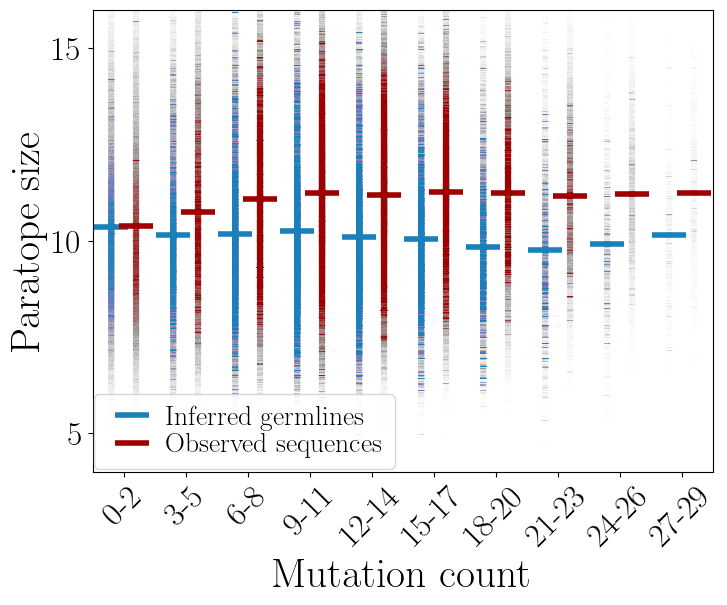

In [11]:

# Process data and call plot_mut
paratope_size_sequences = ig_filtered.query("mutation_count<31")["paratope_size_sequence"].to_list()
mutation_count_sequences =  ig_filtered.query("mutation_count<31")["mutation_count"].to_list()
paratope_size_germlines = ig_filtered.query("mutation_count<31")["paratope_size_germline"].to_list()

plot_mut(mutation_count_sequences, paratope_size_germlines, mutation_count_sequences, paratope_size_sequences, save_name="seq_vs_germ_mut_counts_all", right=False, title="All IgGs")


# ridgeline

In [12]:
ig_filtered['mean_delta_paratope_size'] = ig_filtered.groupby('clone_id')['delta_paratope_size'].transform('mean')
ig_filtered['mean_sequence_paratope_size'] = ig_filtered.groupby('clone_id')['paratope_size_sequence'].transform('mean')

/tmp/ipykernel_2366694/2468983182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ig_filtered['mean_delta_paratope_size'] = ig_filtered.groupby('clone_id')['delta_paratope_size'].transform('mean')
/tmp/ipykernel_2366694/2468983182.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ig_filtered['mean_sequence_paratope_size'] = ig_filtered.groupby('clone_id')['paratope_size_sequence'].transform('mean')


In [13]:
# Group by clone_id and calculate all required metrics
grouped_df = (
    ig_filtered.groupby('clone_id')
    .agg(
        mean_delta_paratope_size=('delta_paratope_size', 'mean'),
        mean_sequence_paratope_size=('paratope_size_sequence', 'mean'),
        clone_size=('clone_id', 'count')
    )
    .reset_index()
)

# Now extract the columns as lists if needed
mean_delta_paratope_sizes = grouped_df['mean_delta_paratope_size'].tolist()
mean_paratope_sizes = grouped_df['mean_sequence_paratope_size'].tolist()
clone_sizes = grouped_df['clone_size'].tolist()


1-3
4-7
8-15
16-31
32-63
64-127
128-255
256-511
512+


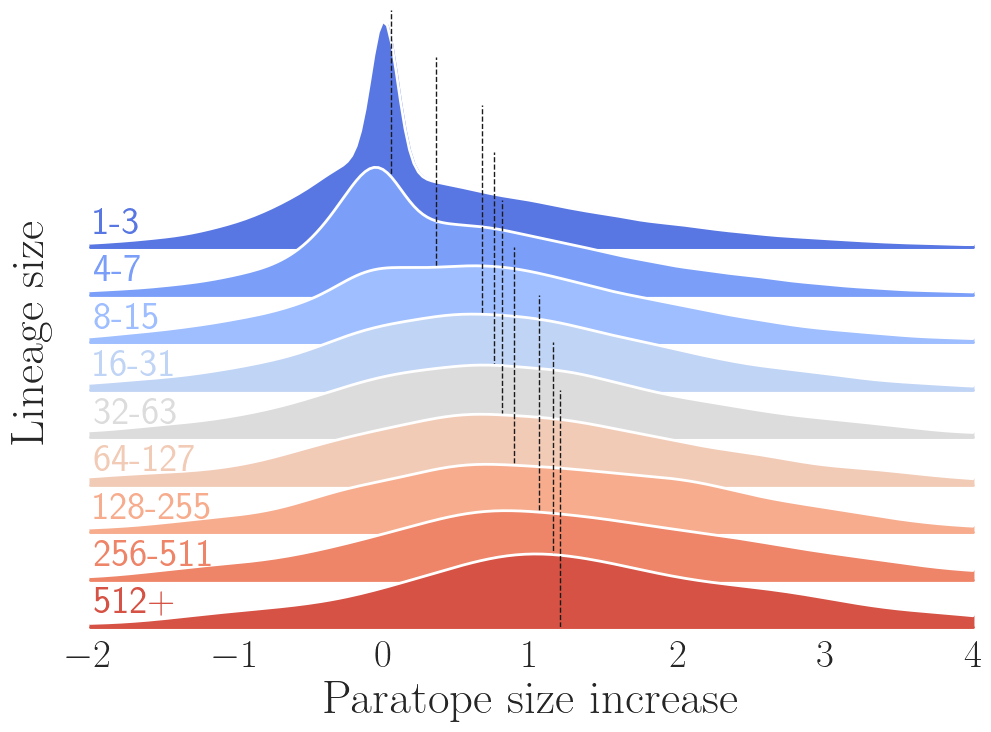

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Assuming clone_sizes and mean_delta_paratope_sizes are defined
plt.rcParams.update({
    "axes.labelsize": 30,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "legend.fontsize": 20,
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
})
custom_bins = [1, 4, 8, 16, 32, 64, 128, 256, 512, np.inf]
bin_labels = ['1-3', '4-7', '8-15', '16-31', '32-63', '64-127', '128-255', '256-511', '512+']

bin_indices = np.digitize(clone_sizes, bins=custom_bins, right=False)
data = pd.DataFrame({
    'Clone Size': clone_sizes,
    'Mean Delta Paratope Size': mean_delta_paratope_sizes,
    'Bin': bin_indices
})
data['Bin Label'] = data['Bin'].apply(lambda x: bin_labels[x-1] if 0 < x <= len(bin_labels) else 'Outlier')
data['Mean Delta Paratope Size'] = pd.to_numeric(data['Mean Delta Paratope Size'], errors='coerce')
data['Bin Label'] = pd.Categorical(data['Bin Label'], categories=bin_labels, ordered=True)

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

pal = sns.color_palette('coolwarm', n_colors=len(bin_labels))
g = sns.FacetGrid(data, row='Bin Label', hue='Bin Label', aspect=12, height=0.8, palette=pal)

bw_val = 1.5
xlim_lower, xlim_upper = -2, 4

g.map_dataframe(sns.kdeplot,
                x='Mean Delta Paratope Size',
                bw_adjust=1, clip_on=False,
                fill=True, alpha=1, linewidth=1.5,
                clip=(xlim_lower, xlim_upper),
                )

g.map_dataframe(sns.kdeplot,
                x='Mean Delta Paratope Size',
                bw_adjust=1, clip_on=False,
                color="w", lw=2,
                clip=(xlim_lower, xlim_upper))

g.map(plt.axhline, y=0, lw=2, clip_on=False)

label_x = xlim_lower + 0.03
for ax, label in zip(g.axes.flat, bin_labels):
    print(label)
    ax.text(label_x, 0.06, label, fontweight='bold', fontsize=28, color=ax.lines[-1].get_color())
    subset = data[data['Bin Label'] == label]['Mean Delta Paratope Size']
    median_val = subset.median()
    ax.axvline(median_val, color='k', linestyle='--', lw=1)  # Median line

g.fig.subplots_adjust(hspace=-0.8)
g.set_titles("")
g.set_ylabels("")  # Removes y-axis labels on all facets

g.set(xlim=(xlim_lower, xlim_upper))  # no yticks in FacetGrid-level set()
g.set_axis_labels(r"$\mathrm{Paratope\ size\ increase}$", "")

for ax in g.axes.flatten():
    ax.set_xlabel(r"$\mathrm{Paratope\ size\ increase}$", fontsize=34)
    ax.set_yticks([])  # remove y-ticks
    ax.tick_params(axis='x', labelsize=28)
g.despine(bottom=True, left=True)
g.fig.text(-0.0, 0.5, r"$\mathrm{Lineage\ size}$", ha='center', va='center', rotation='vertical', fontsize=34)
plt.savefig("/home/athenes/Paraplume/data_with_scripts/plots/figure5C.svg", bbox_inches="tight")
plt.show()


# control for mutations

In [15]:
print(grouped_df.query("clone_size==1")["mean_delta_paratope_size"].mean())

0.38586513706782105


/tmp/ipykernel_2366694/2784994143.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ig_filtered["clone_size"] = ig_filtered["clone_id"].map(ig_filtered["clone_id"].value_counts())


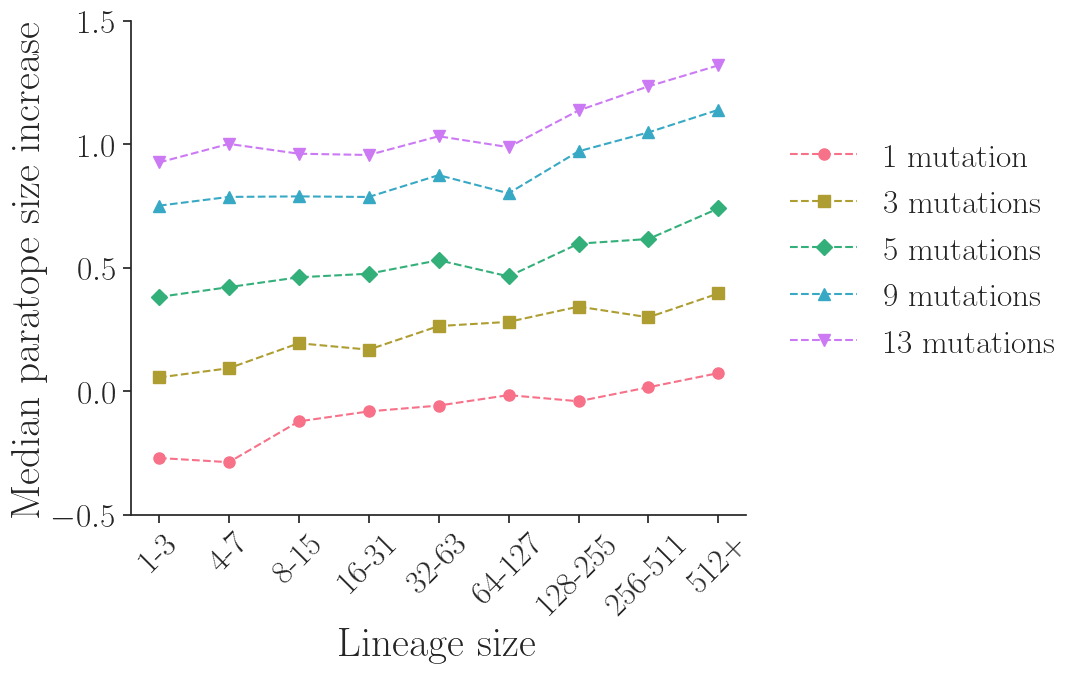

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.rcParams.update({
    "axes.labelsize": 30,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "legend.fontsize": 24,
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
})
# Custom bin settings
custom_bins = [1, 4, 8, 16, 32, 64, 128, 256, 512, np.inf]
bin_labels = ['1-3', '4-7', '8-15', '16-31', '32-63', '64-127', '128-255', '256-511', '512+']

# Mutation counts and their colors
mutation_range = [1,3,5,9,13]  # e.g. [1, 5, 9, 13, 17]
colors = sns.color_palette("husl", n_colors=len(mutation_range))
mutation_color_map = {mut: colors[i] for i, mut in enumerate(mutation_range)}

# Markers for each mutation count
markers = ['o', 's', 'D', '^', 'v']  # Extend if needed
mutation_marker_map = {mut: markers[i % len(markers)] for i, mut in enumerate(mutation_range)}

# Prepare data container
all_data = []

# Assuming ig_filtered dataframe exists and has columns 'clone_id', 'mutation_count', 'delta_paratope_size'
ig_filtered["clone_size"] = ig_filtered["clone_id"].map(ig_filtered["clone_id"].value_counts())

for mut in mutation_range:
    grouped_df = (
        ig_filtered.query("mutation_count == @mut")
        .groupby('clone_id')
        .agg(
            mean_delta_paratope_size=('delta_paratope_size', 'mean'),
            clone_size=('clone_size', 'mean')
        )
        .reset_index()
    )

    if grouped_df.empty:
        continue

    grouped_df['Bin'] = np.digitize(grouped_df['clone_size'], bins=custom_bins, right=False)
    grouped_df['Bin Label'] = grouped_df['Bin'].apply(
        lambda x: bin_labels[x - 1] if 0 < x <= len(bin_labels) else 'Outlier'
    )
    grouped_df['Mutation'] = mut
    all_data.append(grouped_df)

# Combine all mutation data
data_combined = pd.concat(all_data, ignore_index=True)

# Compute median and IQR per Bin Label and Mutation
summary = (
    data_combined.groupby(['Mutation', 'Bin Label'])
    .agg(
        median_delta=('mean_delta_paratope_size', 'median'),
        q1=('mean_delta_paratope_size', lambda x: np.percentile(x, 25)),
        q3=('mean_delta_paratope_size', lambda x: np.percentile(x, 75))
    )
    .reset_index()
)

# Plot setup
plt.figure(figsize=(14, 6))

for mut in mutation_range:
    subset = summary[summary['Mutation'] == mut]
    if subset.empty:
        continue
    # Ensure bin order on x-axis
    subset = subset.set_index('Bin Label').reindex(bin_labels).reset_index()
    if mut>1:
        label=f'{mut} mutations'
    else:
        label=f'{mut} mutation'
    plt.errorbar(
        x=subset['Bin Label'],
        y=subset['median_delta'],
        yerr=None,  # IQR as error bars
        fmt=mutation_marker_map[mut],
        label=label,
        color=mutation_color_map[mut],
        linestyle='--',
        capsize=5,
        markersize=8,
    )

plt.xlabel("Lineage size")
plt.ylabel("Median paratope size increase")
plt.yticks(np.arange(-0.5, 1.6, 0.5))  # y-axis ticks: -0.5, 0.0, 0.5, 1.0, 1.5
plt.xticks(ticks=range(len(bin_labels)), labels=bin_labels, rotation=45)
plt.ylim([-0.5, 1.5])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y', which='both', left=True,  labelleft=True)

# Legend outside on the right, no box background
plt.legend(
    bbox_to_anchor=(1.05, 0.78),
    loc='upper left',
    borderaxespad=0.,
    frameon=False
)

plt.tight_layout(rect=[0, 0, 0.8, 1.15])  # Leave space on right for legend

# Save and show
sns.despine(top=True, right=True)  # <-- Remove top and right spines

plt.savefig("/home/athenes/Paraplume/data_with_scripts/plots/figure5D.svg", bbox_inches="tight")
plt.show()
